/home/steinbac/software/tifffile/0.8/python3/lib64/python3.4/site-packages/tifffile-0.8.0-py3.4-linux-x86_64.egg/tifffile/tifffile.py:263: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


(108, 1352, 532) (92, 1024, 512)


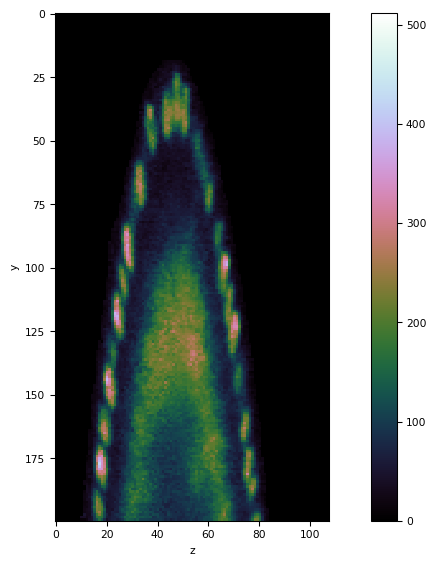

In [2]:
%matplotlib inline
import tifffile
import blosc
import numpy as np

blosc.set_nthreads(1)

royer1 = "/scratch/steinbac/sqeasy_data/xwing/droso-royer-may31-000005.tif"
xwingr = tifffile.imread(royer1)

haase1 = "/scratch/steinbac/sqeasy_data/xwing/000195-rhaase-20171129-fused-512x1024x92.tif"
xwingh = tifffile.imread(haase1)

smallr = xwingr[:,:200,:]
smallh = xwingh[:,:200,:]

sizes = {"smallr" : len(smallr.tobytes()), "smallh" : len(smallh.tobytes())}
print(xwingr.shape,xwingh.shape)
ax = tifffile.imshow(smallr[:,:,int(smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

# study of frame shuffle

- reorder frames along z along rising mean/median

(108, 200, 532)
108 200 532
(92, 200, 512)
92 200 512


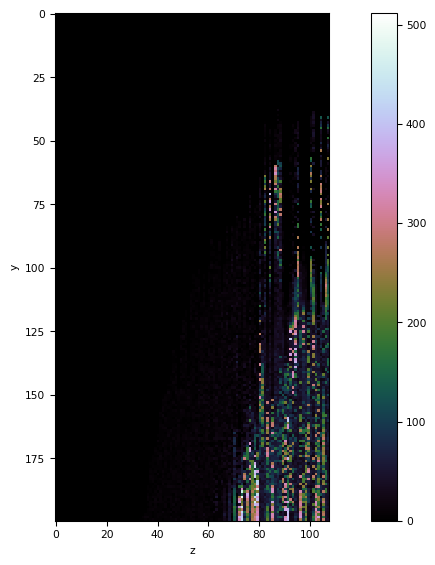

In [12]:
def framelinepixel_shuffle(_data):
    
    if len(_data.shape) != 3:
        print("data is not 3D!")
        return _data
    
    sof = [] #sum_of_frame
    sol = [] #sum_of_lines
    soc = [] #sum_of_columns
    
    for z in range(_data.shape[0]):
        frame = _data[z,:,:]
        sof.append(np.sum(frame))
        sol.append(list(np.sum(frame,axis=1)))
        soc.append(list(np.sum(frame,axis=0)))
        
    print(_data.shape)
    print(len(sof),len(sol[0]),len(soc[0]))
    assert len(sof) == _data.shape[0]
    assert len(sol[0]) == _data.shape[1]
    assert len(soc[0]) == _data.shape[-1]
    
    sorted_sof = sorted(sof)
    sorted_sol = [ sorted(v) for v in sol ]
    sorted_soc = [ sorted(v) for v in soc ]
    
    value = np.zeros_like(_data)
       
    for z in range(_data.shape[0]):
        src_z_index = sof.index(sorted_sof[z])
        
        for y in range(_data.shape[1]):
            src_y_index = sol[src_z_index].index(sorted_sol[src_z_index][y])
            for x in range(_data.shape[-1]):
                src_x_index = soc[src_z_index].index(sorted_soc[src_z_index][x])
                value[z,y,x] = _data[src_z_index,src_y_index,src_x_index]
        
    return value

sorted_smallr = framelinepixel_shuffle(smallr)
sorted_smallh = framelinepixel_shuffle(smallh)

ax = tifffile.imshow(sorted_smallr[:,:,int(sorted_smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

In [13]:
import math
import time

strd = {blosc.BITSHUFFLE : "bitshuffle", 
        blosc.NOSHUFFLE : "none", 
        None : "none" , 
        blosc.SHUFFLE : "byteshuffle"}

def compress_list(datum,shufflemode = blosc.BITSHUFFLE, clevel = 5, engine="lz4"):
    
          
    start = time.time()
    compressed = blosc.compress(datum.tobytes(),shuffle=shufflemode,clevel=clevel,cname=engine)
    end = time.time()   
    value = ((len(datum.tobytes()),len(compressed),end-start,"%s-%i-%s" % (engine,clevel,strd[shufflemode])))
    return value

bitshuffled_nbytes = {}
bitshuffled_nbytes["smallr"] = compress_list(smallr)
bitshuffled_nbytes["smallh"] = compress_list(smallh)
bitshuffled_nbytes["smallr_sorted"] = compress_list(sorted_smallr)
bitshuffled_nbytes["smallh_sorted"] = compress_list(sorted_smallh)
bitshuffled_nbytes["smallr-noshuffle"] = compress_list(smallr,shufflemode=blosc.NOSHUFFLE)
bitshuffled_nbytes["smallh-noshuffle"] = compress_list(smallh,shufflemode=blosc.NOSHUFFLE)
bitshuffled_nbytes["smallr_sorted-noshuffle"] = compress_list(sorted_smallr,shufflemode=blosc.NOSHUFFLE)
bitshuffled_nbytes["smallh_sorted-noshuffle"] = compress_list(sorted_smallh,shufflemode=blosc.NOSHUFFLE)

bitshuffled_nbytes["smallr-8"] = compress_list(smallr,clevel=8)
bitshuffled_nbytes["smallh-8"] = compress_list(smallh,clevel=8)
bitshuffled_nbytes["smallr_sorted-8"] = compress_list(sorted_smallr,clevel=8)
bitshuffled_nbytes["smallh_sorted-8"] = compress_list(sorted_smallh,clevel=8)
bitshuffled_nbytes["smallr-2"] = compress_list(smallr,clevel=2)
bitshuffled_nbytes["smallh-2"] = compress_list(smallh,clevel=2)
bitshuffled_nbytes["smallr_sorted-2"] = compress_list(sorted_smallr,clevel=2)
bitshuffled_nbytes["smallh_sorted-2"] = compress_list(sorted_smallh,clevel=2)


In [14]:
def summary(cdic):
    max_label_size = max([ len(k) for k in cdic.keys()])
    
    print(("%"+str(max_label_size)+"s %20s %10s %10s %8s %10s")%("","info","inbytes","outbytes","ratio", "bw [MB/s]"))
    for (k,item) in cdic.items():
        
        ratio = item[0]/item[1]
        bw = item[0]/(1024.*1024.*item[2])
        print(("%"+str(max_label_size)+"s %20s %10i %10i %8.2f %10.2f") % (k,item[-1],item[0],item[1],ratio,bw))
            
summary(bitshuffled_nbytes)

                                        info    inbytes   outbytes    ratio  bw [MB/s]
                 smallr     lz4-5-bitshuffle   22982400    3789107     6.07     134.75
                 smallh     lz4-5-bitshuffle   18841600    4464109     4.22     138.50
          smallr_sorted     lz4-5-bitshuffle   22982400    3945425     5.83     249.76
          smallh_sorted     lz4-5-bitshuffle   18841600    4418820     4.26     259.81
       smallr-noshuffle           lz4-5-none   22982400    4864902     4.72     236.60
       smallh-noshuffle           lz4-5-none   18841600   11415619     1.65     167.66
smallr_sorted-noshuffle           lz4-5-none   22982400    5130444     4.48    1722.40
smallh_sorted-noshuffle           lz4-5-none   18841600   10805251     1.74     412.19
               smallr-8     lz4-8-bitshuffle   22982400    3647688     6.30     142.93
               smallh-8     lz4-8-bitshuffle   18841600    4362905     4.32     145.43
        smallr_sorted-8     lz4-8-bitshuffl